In [1]:
import os
import csv
from PIL import Image
import numpy as np
import numpy.linalg as la
from scipy import linalg
from scipy import spatial
from scipy import signal
import matplotlib.pyplot as plt
from math import *
import time

%matplotlib inline

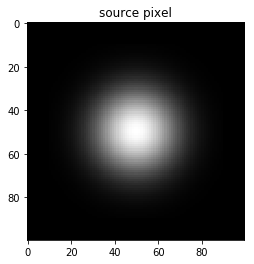

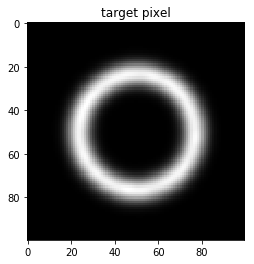

In [7]:
###x: Generate an image of 2D Gaussian kernel, with image size of 100x100 pixels###
###y: Generate an image of 2D annulus, with image size of 100x100 pixels###
def rho_T(x,T,rho_x,delta = 1e3):
    T0 = T[:,0]
    T1 = T[:,1]
    x0T0 = x[0]-T[:,0]
    x1T1 = x[1]-T[:,1]
    argexp = -delta*(x0T0**2+x1T1**2)
    exp_v = np.exp(argexp)
    return exp_v.dot(rho_x)
def gkern(kernlen, std):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d
def annulus(L,W):
    r = np.random.normal(0.9,0.1,100000)
    theta = 2*pi*np.random.uniform(0,1,100000)
    y_0 = np.zeros((100000,2))
    y_0[:,0]=0.3*r*np.cos(theta)+0.5
    y_0[:,1]=0.3*r*np.sin(theta)+0.5
    x_0 = np.zeros((L*W,2))
    for i in range(L*W):
        x_0[i][0] = (i//W)/L
        x_0[i][1] = (i%W)/W

    w = np.array(100000*[1e-5])
    pixels = np.array([rho_T(x_0[i], y_0[:,:2],w,delta = 1e3) for i in range(len(x_0))])
    n_pixels = np.array([1.0/pixels.sum()*pixels])
    x = np.concatenate((x_0,n_pixels.T), axis=1)
    
    return x, pixels
def Gaussian_pixels(L1,W1,sizeG,std,nml):
    x_0 = np.zeros((L1*W1,2))
    for i in range(L1*W1):
        x_0[i][0] = (i//W1)/L1
        x_0[i][1] = (i%W1)/W1

    # y_0 = x_0

    Gaussian_1 = gkern(sizeG,std)
    
    rec_x = np.zeros((L1,W1))
    rec_x[10:sizeG+10,10:sizeG+10] = Gaussian_1

    pixels_1 = rec_x.flatten()+1e-23
    n_pixels_1 = np.array([1.0/pixels_1.sum()*pixels_1])

    x = np.concatenate(((L1/nml)*x_0,n_pixels_1.T),axis=1)
    
    return x,pixels_1
x,pixels_1 = Gaussian_pixels(100,100,80,13,100)
y,pixels_2 = annulus(100,100)
image_count = 0
faceX = np.reshape(pixels_1,(100,100))
image_count+=1
plt.figure(image_count)
plt.title('source pixel')
plt.imshow(faceX,cmap=plt.cm.gray)
# plt.show('hold')

faceX = np.reshape(pixels_2,(100,100))
image_count+=1
plt.figure(image_count)
plt.title('target pixel')
plt.imshow(faceX,cmap=plt.cm.gray)
# plt.show('hold')

In [8]:
##Initialization of interpolation 
def cutoff(x):
    ###drop pixels with intensity below a certain level; this case we drop pixels with intensity value 0
    nx = []
    for i in range(len(x)):
        if x[i][2] != 0:
            nx.append(x[i])
    return np.array(nx)

def Tx(x,y):
    ###Explicit optimal transport map from a Gaussian distribution (mx,vx) to another Gaussian distribution (my,vy)
    x_0 = x[:,:2]
    y_0 = y[:,:2]
    mx = np.average(x_0,axis=0,weights = x[:,2])
    my = np.average(y_0,axis=0,weights = y[:,2])
    vx = np.cov(x_0.T,aweights = x[:,2])
    vy = np.cov(y_0.T,aweights = y[:,2])
    
    
    sqrt = linalg.sqrtm(vx)
    ml = np.matmul(sqrt,vy)
    m = np.matmul(ml,sqrt)
    sqrt_inv = la.inv(sqrt)
    l = np.matmul(sqrt_inv,linalg.sqrtm(m))
    A = np.matmul(l,sqrt_inv)
    
    x_T = np.zeros((len(x),2))
    x_T = my+np.einsum('ij,jk->ik',A,(x_0-mx).T).T
    
    return x_T
    
def Ty(y,x):
    ###Explicit optimal transport map from a Gaussian distribution (my,vy) to another Gaussian distribution (mx,vx)
    x_0 = x[:,:2]
    y_0 = y[:,:2]
    mx = np.average(x_0,axis=0,weights = x[:,2])
    my = np.average(y_0,axis=0,weights = y[:,2])
    vx = np.cov(x_0.T,aweights = x[:,2])
    vy = np.cov(y_0.T,aweights = y[:,2])
    
    sqrt = linalg.sqrtm(vy)
    ml = np.matmul(sqrt,vx)
    m = np.matmul(ml,sqrt)
    sqrt_inv = la.inv(sqrt)
    l = np.matmul(sqrt_inv,linalg.sqrtm(m))
    A = np.matmul(l,sqrt_inv)
    
    y_T = np.zeros((len(y),2))
    y_T = mx+np.einsum('ij,jk->ik',A,(y_0-my).T).T
    
    return y_T

def compose(x,y,p):
    twx = x.sum(axis=0)[2]
    twy = y.sum(axis=0)[2]
    
    x[:,2] = p/twx*x[:,2]
    y[:,2] = (1-p)/twy*y[:,2]
    
    return np.concatenate([x,y])

####two ways to initialize intermediate sets of points, interpolate_1 picks points using weights of each points
####interpolate_2 picks points with uniform probability
####interpolate_2 works better in practice
def interpolate_1(x,y,K):
    Nx = len(x)
    Ny = len(y)
    d1 = np.arange(Nx)
    d2 = np.arange(Ny)
    wx = x[:,2]
    wy = y[:,2]
    
    x_T = Tx(x,y)
    x_K = x_T
    y_T = Ty(y,x)
    mu = []
    mu.append(x)
    
    z0k = np.zeros((Nx,3))
    zKk = np.zeros((Ny,3))
    z0k[:,2] = x[:,2]
    zKk[:,2] = y[:,2]
    rx = np.random.choice(d1, Nx,replace=False, p=wx)
    ry = np.random.choice(d2, Ny,replace=False, p=wy)
    for k in range(1,K):
        z0k[:,:2] = (1-k/K)*x[:,:2]+(k/K)*x_T[:,:2]
        zx = z0k[rx]
        rx_sum=0
        for i in range(Nx):
            if rx_sum >= 1-k/K:
                break
            rx_sum += zx[i][2]
        

        zKk[:,:2] = (1-k/K)*y_T[:,:2]+(k/K)*y[:,:2]
        zy = zKk[ry]
        ry_sum=0
        for j in range(Ny):
            if ry_sum >= k/K:
                break
            ry_sum += zy[j,2]
        z = compose(zx[:i],zy[:j],1-k/K)
        mu.append(z)
    mu.append(y)
    
    return mu,x_K,y_T 

def interpolate_2(x,y,K):
    Nx = len(x)
    Ny = len(y)
    wx = x[:,2]
    wy = y[:,2]
    
    x_T = Tx(x,y)
    x_K = x_T
    y_T = Ty(y,x)
    mu = []
    mu.append(x)
    
    z0k = np.zeros((Nx,3))
    zKk = np.zeros((Ny,3))
    z0k[:,2] = x[:,2]
    zKk[:,2] = y[:,2]
    
    rx = np.random.choice(np.arange(Nx),Nx,replace=False)
    ry = np.random.choice(np.arange(Ny),Ny,replace=False)
    
    for k in range(1,K):
        z0k[:,:2] = (1-k/K)*x[:,:2]+(k/K)*x_T[:,:2]
        zx = z0k[rx]
        
        

        zKk[:,:2] = (1-k/K)*y_T[:,:2]+(k/K)*y[:,:2]
        zy = zKk[ry]
        z = compose(zx[:int(Nx*(1-k/K))],zy[:int(Ny*k/K)],1-k/K)
        mu.append(z)
    mu.append(y)
    
    return mu, x_K,y_T

def interpolate_linear(x,y,K):
    Nx = len(x)
    Ny = len(y)
    x_T = Tx(x,y)
    x_K = x_T
    y_T = Ty(y,x)
    mu = []
    mu.append(x)
    for k in range(1,K):
        l = np.zeros((Nx,3))
        l[:,:2] = (1-k/K)*x[:,:2]+(k/K)*x_T[:,:2]
        l[:,2] = x[:,2]
        
        mu.append(l)
    mu.append(y)
    
    return mu,x_K,y_T

In [10]:
##Local OT
def LGH(x,y,a,b,returnGH=True,d=2):
    da = len(a)
    db = len(b)
    Nx = len(x)
    Ny = len(y)
    
    x0 = x[:,0]
    x1 = x[:,1]
    x0a6 = x0+a[6]
    x1a7 = x1+a[7]
    argexpT = (x0a6**2+x1a7**2)
    expT = np.exp(-0.5*argexpT)
    T = np.zeros((Nx,2))
    T[:,0] = a[0] + (1+a[2])*x0+a[3]*x1+a[5]*x0a6*expT
    T[:,1] = a[1] + a[3]*x0+(1+a[4])*x1+a[5]*x1a7*expT
    T0 = T[:,0]
    T1 = T[:,1]
    y0 = y[:,0]
    y1 = y[:,1]
    g0y = b[0]+ b[1]*y0+b[2]*y1+0.5*b[3]*y0**2+b[4]*y0*y1+0.5*b[5]*y1**2
    y0b7 = y0+b[7]
    y1b8 = y1+b[8]
    y0b10 = y0+b[10]
    y1b11 = y1+b[11]
    argexpy1 =  (y0b7**2+y1b8**2)
    expy1 = np.exp(-0.5*argexpy1)
    argexpy2 =  (y0b10**2+y1b11**2)
    expy2 = np.exp(-0.5*argexpy2)
    g1y = b[6]*expy1
    g2y = b[9]*expy2
    gy = g0y + g1y + g2y
    g0T =b[0]+ b[1]*T0+b[2]*T1+0.5*b[3]*T0**2+b[4]*T0*T1+0.5*b[5]*T1**2
    T0b7 = T0+b[7]
    T1b8 = T1+b[8]
    T0b10 = T0+b[10]
    T1b11 = T1+b[11]
    argexpT1 =  (T0b7**2+T1b8**2)
    expT1 = np.exp(-0.5*argexpT1)
    argexpT2 =  (T0b10**2+T1b11**2)
    expT2 = np.exp(-0.5*argexpT2)
    g1T = b[6]*expT1
    g2T = b[9]*expT2
    gT = g0T + g1T + g2T
    
    L = np.average(gT,weights=x[:,2]) - np.average(np.exp(gy),weights=y[:,2])
    
    if not returnGH:
        return(L)
    
    else:
        #first derivatives
        gzT = np.zeros((Nx,2))
        gzT[:,0] = b[1]+b[3]*T0+b[4]*T1
        gzT[:,0] += -b[6]*T0b7*expT1
        gzT[:,0] += -b[9]*T0b10*expT2
        gzT[:,1] = b[2]+b[4]*T0+b[5]*T1
        gzT[:,1] += -b[6]*T1b8*expT1
        gzT[:,1] += -b[9]*T1b11*expT2
        
        daT = np.zeros((Nx,da,d))
        daT[:,0,:] = np.array([1,0])
        daT[:,1,:] = np.array([0,1])
        daT[:,2,0] = x0
        daT[:,3,0] = x1
        daT[:,3,1] = x0
        daT[:,4,1] = x1
        
        daT[:,5,0] = expT*x0a6
        daT[:,5,1] = expT*x1a7
        daT[:,6,0] = a[5]*expT*(1-x0a6**2)
        daT[:,6,1] = -a[5]*expT*x0a6*x1a7
        daT[:,7,0] = daT[:,6,1]
        daT[:,7,1] = a[5]*expT*(1-x1a7**2)
        
        #gradient w.r.t. a
        ngzT = np.einsum('i,ij->ij',x[:,2],gzT)
        daL = np.einsum('ijk,ik->j',daT,ngzT)
        
        expgy = np.exp(gy)
        nexpgy = np.exp(gy)*y[:,2]
        dbgy = np.zeros((Ny,db))
        dbgT = np.zeros((Nx,db))
        dbgy[:,0] = np.ones(Ny)
        dbgT[:,0] = np.ones(Nx)
        dbgy[:,1] = y0
        dbgT[:,1] = T0
        dbgy[:,2] = y1
        dbgT[:,2] = T1
        dbgy[:,3] = 0.5*y0**2
        dbgT[:,3] = 0.5*T0**2
        dbgy[:,4] = y0*y1
        dbgT[:,4] = T0*T1
        dbgy[:,5] = 0.5*y1**2
        dbgT[:,5] = 0.5*T1**2
        
        dbgy[:,6] = expy1
        dbgT[:,6] = expT1
        dbgy[:,7] = -b[6]*y0b7*expy1
        dbgT[:,7] = -b[6]*T0b7*expT1
        dbgy[:,8] = -b[6]*y1b8*expy1
        dbgT[:,8] = -b[6]*T1b8*expT1
        dbgy[:,9] = expy2
        dbgT[:,9] = expT2
        
        dbgy[:,10] = -b[9]*y0b10*expy2
        dbgT[:,10] = -b[9]*T0b10*expT2
        dbgy[:,11] = -b[9]*y1b11*expy2
        dbgT[:,11] = -b[9]*T1b11*expT2
        
        #gradient w.r.t. b
        ndbgT = np.einsum('i,ij->ij',x[:,2],dbgT)
        dbL = np.sum(ndbgT,axis=0) - np.einsum('ik,i->k',dbgy,nexpgy)
        
        #gradient
        G = np.concatenate([daL,dbL],axis=0)
        
        #second derivatives
        gzzT = np.zeros((Nx,d,d))
        gzzT[:,0,0] = b[3] - b[6]*(1-T0b7**2)*expT1-b[9]*(1-T0b10**2)*expT2
        gzzT[:,1,0] = b[4] + b[6]*T0b7*T1b8*expT1+b[9]*T0b10*T1b11*expT2
        gzzT[:,0,1] = gzzT[:,1,0]
        gzzT[:,1,1] = b[5] - b[6]*(1-T1b8**2)*expT1-b[9]*(1-T1b11**2)*expT2
        
        daaT = np.zeros((Nx,da,da,d))
        
        daaT[:,5,6,0] = expT*(1-x0a6**2)
        daaT[:,5,6,1] = -expT*x0a6*x1a7
        daaT[:,5,7,0] = daaT[:,5,6,1]
        daaT[:,5,7,1] = expT*(1-x1a7**2)
        daaT[:,6,6,0] = -a[5]*expT*x0a6*(3-x0a6**2)
        daaT[:,6,6,1] = -a[5]*expT*x1a7*(1-x0a6**2)
        daaT[:,6,7,0] = daaT[:,6,6,1]
        daaT[:,6,7,1] = -a[5]*expT*(1-x1a7**2)*x0a6
        daaT[:,7,7,0] = daaT[:,6,7,1]
        daaT[:,7,7,1] = -a[5]*expT*x1a7*(3-x1a7**2)
        
        daaT[:,6,5,0] = daaT[:,5,6,0]
        daaT[:,6,5,1] = daaT[:,5,6,1]
        daaT[:,7,5,0] = daaT[:,5,7,0]
        daaT[:,7,5,1] = daaT[:,5,7,1]
        daaT[:,7,6,0] = daaT[:,6,7,0]
        daaT[:,7,6,1] = daaT[:,6,7,1]
   
        ngzzT = np.einsum('i,ijk->ijk',x[:,2],gzzT)
        daaL = np.einsum('ijkl,il->jk',daaT,ngzT) + np.einsum('ijl,ilm,ikm->jk',daT,ngzzT,daT)
        
        
        
        
        dbzgT = np.zeros((Nx,db,d))
        dbzgT[:,1,0]=np.ones(Nx)
        dbzgT[:,2,1]=np.ones(Nx)
        dbzgT[:,3,0]=T0
        dbzgT[:,4,0]=T1
        dbzgT[:,4,1]=T0
        dbzgT[:,5,1]=T1
        
        dbzgT[:,6,0]=-T0b7*expT1
        dbzgT[:,6,1]=-T1b8*expT1
        dbzgT[:,7,0]=-b[6]*expT1*(1-T0b7**2)
        dbzgT[:,7,1]=b[6]*T1b8*expT1*T0b7
        dbzgT[:,8,0]=dbzgT[:,7,1]
        dbzgT[:,8,1]=-b[6]*expT1*(1-T1b8**2)
        dbzgT[:,9,0]=-T0b10*expT2
        dbzgT[:,9,1]=-T1b11*expT2
        dbzgT[:,10,0]=-b[9]*expT2*(1-T0b10**2)
        dbzgT[:,10,1]=b[9]*T1b11*expT2*T0b10
        dbzgT[:,11,0]=dbzgT[:,10,1]
        dbzgT[:,11,1]=-b[9]*expT2*(1-T1b11**2)
        
        
        
        ndbzgT = np.einsum('i,ijk->ijk',x[:,2],dbzgT)
        
        # #Hessian w.r.t. ab
        dabL = np.einsum('ikl,ijl->jk',ndbzgT,daT)
        
        
        dbbgy = np.zeros((Ny,db,db))
        dbbgT = np.zeros((Nx,db,db))
        
        dbbgy[:,6,7] = -y0b7*expy1
        dbbgy[:,6,8] = -y1b8*expy1
        dbbgy[:,7,7] = -b[6]*expy1*(1-y0b7**2)
        dbbgy[:,7,8] = b[6]*y1b8*expy1*y0b7
        dbbgy[:,8,8] = -b[6]*expy1*(1-y1b8**2)
        dbbgy[:,9,10] = -y0b10*expy2
        dbbgy[:,9,11] = -y0b10*expy2
        dbbgy[:,10,10] = -b[9]*expy2*(1-y0b10**2)
        dbbgy[:,10,11] = b[9]*y1b11*expy2*y0b10
        dbbgy[:,11,11] =-b[9]*expy2*(1-y1b11**2)
        
        dbbgy[:,7,6] = dbbgy[:,6,7]
        dbbgy[:,8,6] = dbbgy[:,6,8]
        dbbgy[:,8,7] = dbbgy[:,7,8]
        dbbgy[:,10,9] = dbbgy[:,9,10]
        dbbgy[:,11,9] = dbbgy[:,9,11]
        dbbgy[:,11,10] = dbbgy[:,10,11]
        
        
        dbbgT[:,6,7] = -T0b7*expT1
        dbbgT[:,6,8] = -T1b8*expT1
        dbbgT[:,7,7] = -b[6]*expT1*(1-T0b7**2)
        dbbgT[:,7,8] = b[6]*T1b8*expT1*T0b7
        dbbgT[:,8,8] = -b[6]*expT1*(1-T1b8**2)
        dbbgT[:,9,10] = -T0b10*expT2
        dbbgT[:,9,11] = -T0b10*expT2
        dbbgT[:,10,10] = -b[9]*expT2*(1-T0b10**2)
        dbbgT[:,10,11] = b[9]*T1b11*expT2*T0b10
        dbbgT[:,11,11] =-b[9]*expT2*(1-T1b11**2)
        
        dbbgT[:,7,6] = dbbgT[:,6,7]
        dbbgT[:,8,6] = dbbgT[:,6,8]
        dbbgT[:,8,7] = dbbgT[:,7,8]
        dbbgT[:,10,9] = dbbgT[:,9,10]
        dbbgT[:,11,9] = dbbgT[:,9,11]
        dbbgT[:,11,10] = dbbgT[:,10,11]


        dbgdbg = np.einsum('jn,jm->jnm',dbgy,dbgy)
        ndbbgT = np.einsum('i,ijk->ijk',x[:,2],dbbgT)
        
        dbbL = np.sum(ndbbgT,axis=0) - np.einsum('jnm,j->nm',(dbbgy+dbgdbg),nexpgy)
        
        #Hessian
        H = np.zeros((da+db,da+db))
        H[:da,:da] = daaL
        H[:da,da:] = dabL
        H[da:,:da] = dabL.T
        H[da:,da:] = dbbL
        return(L,G,H)
def local_ot(x, y, Niter=200, eps=1e-5, eta0=0.05, da=8, db=12, eta_min = 1e-4, eta_max=1e6, gamma = 2.3):
    x_c = cutoff(x)
    y_c = cutoff(y)
    Nx = len(x)
    Ny = len(y)

    eta = eta0
    etaC = 2.0

    #setting up initial b, and minvar,D
    vx = np.cov(x[:,:2].T,aweights=x[:,2])
    vy = np.cov(y[:,:2].T,aweights=y[:,2])
#     vx = np.cov(x_c[:,:2].T)
#     vy = np.cov(y_c[:,:2].T)
    mx = np.average(x[:,:2],axis=0,weights=x[:,2])
    my = np.average(y[:,:2],axis=0,weights=y[:,2])

    a0 = np.zeros(da)
    #initial b
    b0 = np.zeros(db)
    B0 = 0.5*(la.inv(vy)-la.inv(vx))
    b0[3] = B0[0,0]
    b0[4] = B0[0,1]+B0[1,0]
    b0[5] = B0[1,1]
    B1 = la.solve(vx,mx) - la.solve(vy,my)
    b0[1] = B1[0]
    b0[2] = B1[1]
    b0[0] = 0.5*(my.dot(la.solve(vy,my)) - mx.dot(la.solve(vx,mx))+np.log(la.det(vy)/la.det(vx)))
    b0[7:9] = 0.1*np.random.uniform(low=-1.0,high=1.0,size=2)
    b0[10:] = 0.1*np.random.uniform(low=-1.0,high=1.0,size=2)

    z = np.concatenate([a0,b0],axis=0)
    J = np.eye(da+db)
    J[da:,da:] *= -1

    #   initialize gradients  
    a = a0
    b = b0
    Ln,Gn,Hn = LGH(x,y,a,b)

    x0 = x[:,0]
    x1 = x[:,1]

    T = np.zeros((Nx,3))
    T[:,0] = z[0] + (1+z[2])*x0+z[3]*x1
    T[:,1] = z[1] + z[3]*x0+(1+z[4])*x1
    T[:,2] = x[:,2]
    
#     ####debug####  
#     listG = []
#     listeta = []
#     Lnn = []
#     Lnnp1 = []
#     Lnp1n = []
#     #############
    
    for n in range(Niter):
        zold = z
        nz = z
        Gn_norm = la.norm(Gn,2)
#         ###################
#         listG.append(la.norm(Gn,2))
#         listeta.append(eta)
#         ###################
        
        if Gn_norm < eps:
            break
        #   delta = (delta0-deltainf)*np.exp(-5*(n+1)/Niter) + deltainf
        validity = False
        eta = min(gamma*eta, eta_max)
        iters = 0
        while(not validity):
            iters += 1
            eta = eta/2.0
            if eta < eta_min:
                break
            dz = -la.solve((1.0/eta)*J+Hn,Gn)
            nz = zold + dz
            Ln1 = LGH(x,y,nz[:da],nz[da:],returnGH=False)
            Lan1 = LGH(x,y,nz[:da],zold[da:],returnGH=False)
            Lbn1 = LGH(x,y,zold[:da],nz[da:],returnGH=False)
            v_0 = (Ln1<=Lbn1+1e-16) and (Lan1<=Ln1+1e-16)
            validity = v_0 or (iters>=10)
        z = z + dz
#         ###################
#         Lnn.append(Ln1)
#         Lnnp1.append(Lbn1)
#         Lnp1n.append(Lan1)
#         ###################
        Ln,Gn,Hn = LGH(x,y,z[:da],z[da:])
    a,b = z[:da],z[da:]
    T = np.zeros((Nx,3))
    T[:,0] = z[0] + (1+z[2])*x0+z[3]*x1
    T[:,1] = z[1] + z[3]*x0+(1+z[4])*x1
    T[:,2] = x[:,2]
    
    return T,a,b

In [11]:
def global_ot(x,y,K=100,Maxiter=100,tol=1e-2):
    x_c = cutoff(x)
    y_c = cutoff(y)
    Nx = len(x)
    Ny = len(y) 
    a_maps = K*[0]
    b_maps = K*[0]
    
    mu, x_K, y_0 = interpolate_2(x_c,y_c,K)
    for niter in range(Maxiter):
        print(niter/Maxiter * 100)#debug
        x_Kold=x_K
        #solve local OT's
        z = x_c
        for k in range(1,K+1):


            print('Step k = '+str(k))
            pixels_z = np.array([rho_T(x[i,:2],z[:,:2],z[:,2]) for i in range(100**2)])
            imgz = np.reshape(pixels_z,(100,100))
            plt.figure(3*(k-1))
            plt.title('Before local OT z')
            plt.imshow(imgz,cmap=plt.cm.gray)
            plt.show('hold')

            pixels_mu = np.array([rho_T(x[i,:2],mu[k][:,:2],mu[k][:,2]) for i in range(100**2)])
            imgmu = np.reshape(pixels_mu,(100,100))
            plt.figure(3*(k-1)+1)
            plt.title('Before local OT mu')
            plt.imshow(imgmu,cmap=plt.cm.gray)
            plt.show('hold')


            #solve local transport problem
            Tloc,a,b = local_ot(z,mu[k],Niter=800,gamma=2.3)


            pixels_T = np.array([rho_T(x[i,:2],Tloc[:,:2],Tloc[:,2]) for i in range(100**2)])
            imgT = np.reshape(pixels_T,(100,100))
            plt.figure(3*(k-1)+2)
            plt.title('After local OT z')
            plt.imshow(imgT,cmap=plt.cm.gray)
            plt.show('hold')

            a_maps[k-1] = a
            b_maps[k-1] = b
            z = Tloc
        x_K = z
    
#         if (1/Nx)*la.norm(x_K[:,:2]-x_Kold[:,:2],2)<tol:
        if x[:,2].dot(x_K[:,:2]-x_Kold[:,:2],2)<tol:    
            break
        #update intermediate distributions
        for k in range(1,K):
            mu[k] = np.zeros((len(x_c),3))
            mu[k][:,:2] = (1-k/K)*x_c[:,:2]+(k/K)*x_K[:,:2]
            mu[k][:,2] = x_c[:,2]

    print('done')
    return x_K,a_maps,b_maps

0.0
Step k = 1


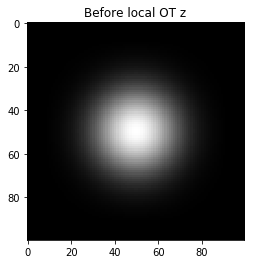

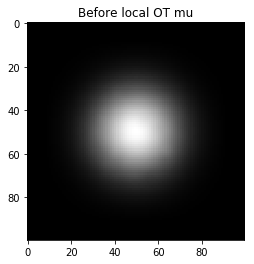

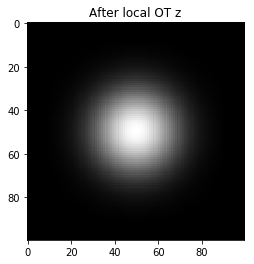

Step k = 2


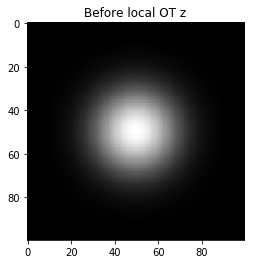

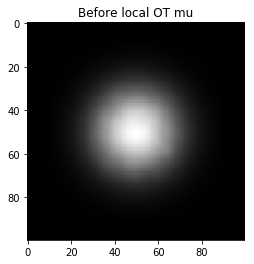

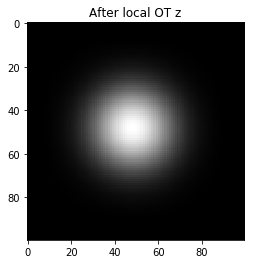

Step k = 3


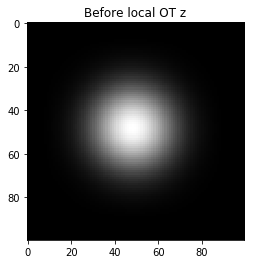

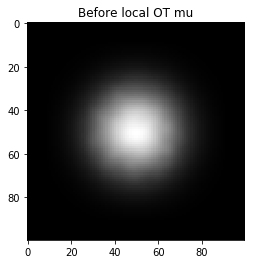

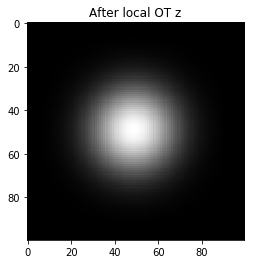

Step k = 4


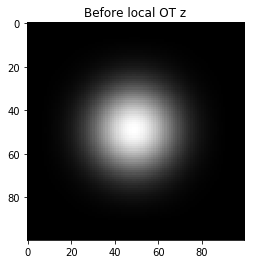

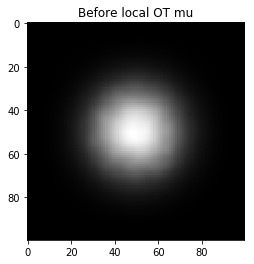

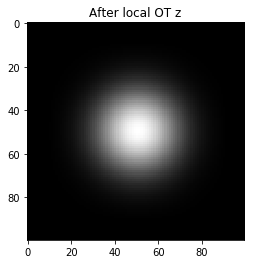

Step k = 5


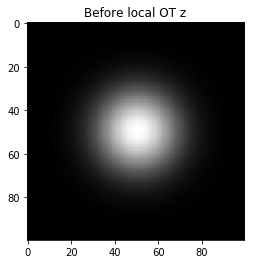

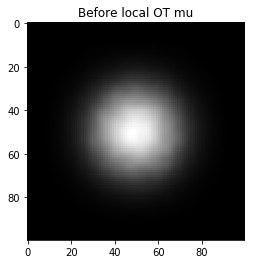

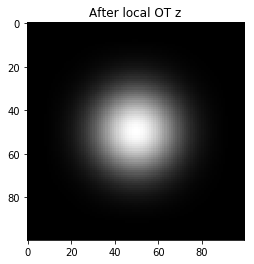

Step k = 6


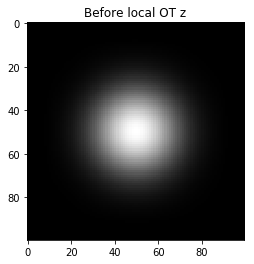

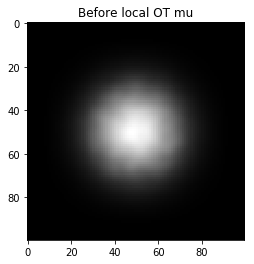

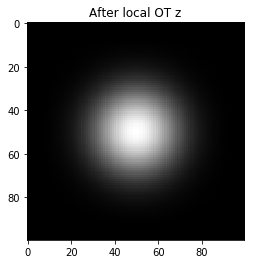

Step k = 7


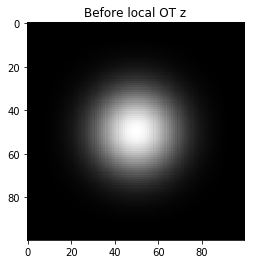

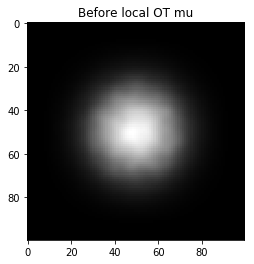

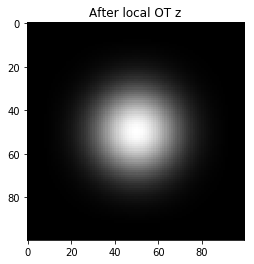

Step k = 8


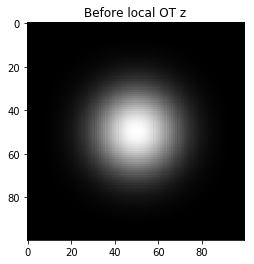

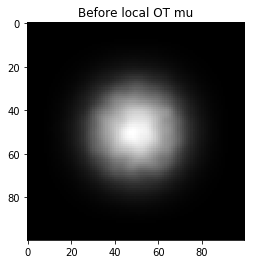

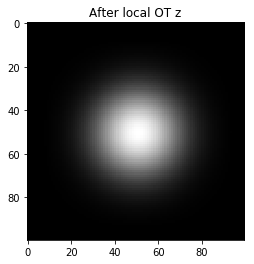

Step k = 9


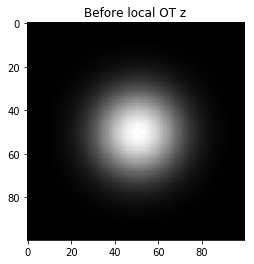

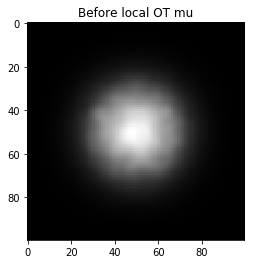

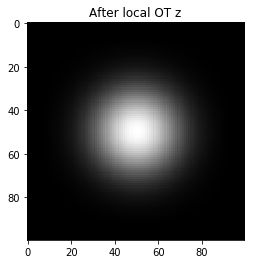

Step k = 10


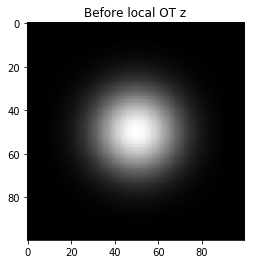

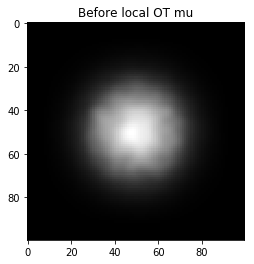

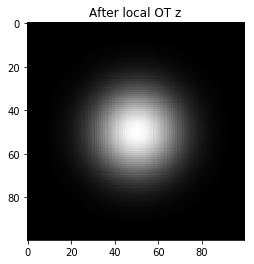

Step k = 11


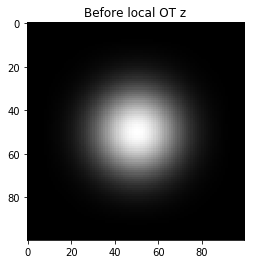

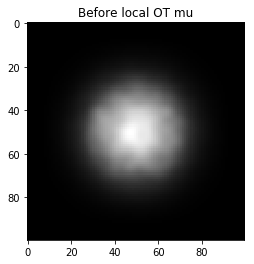

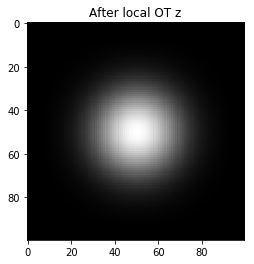

Step k = 12


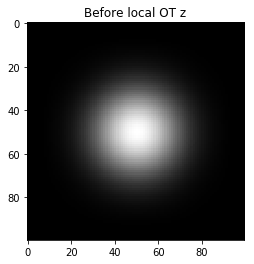

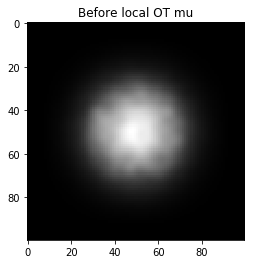

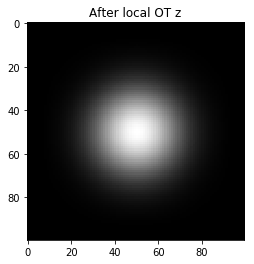

Step k = 13


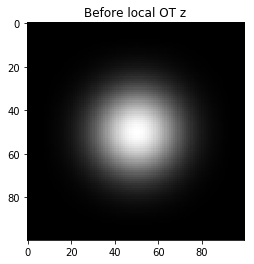

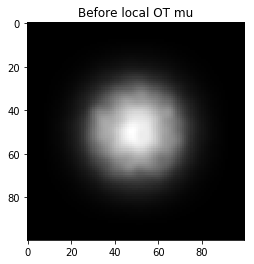

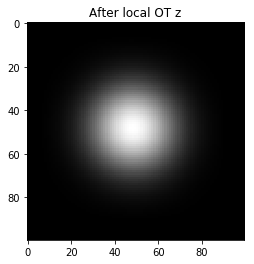

Step k = 14


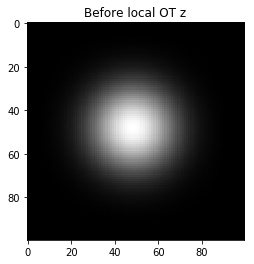

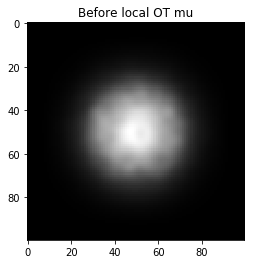

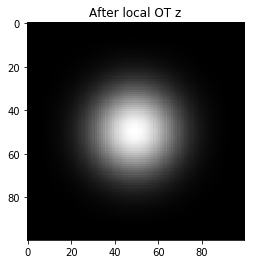

Step k = 15


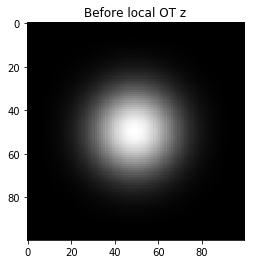

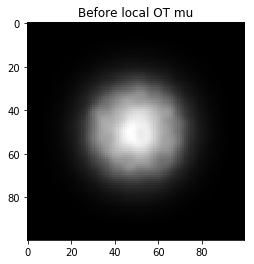

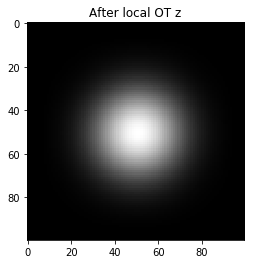

Step k = 16


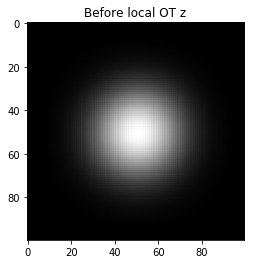

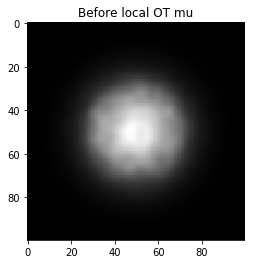

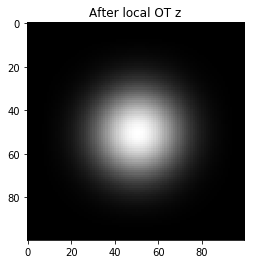

Step k = 17


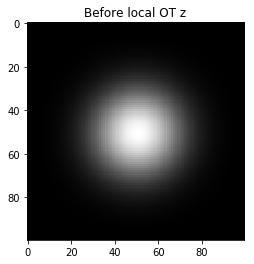

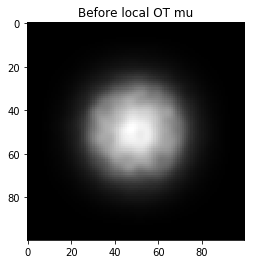

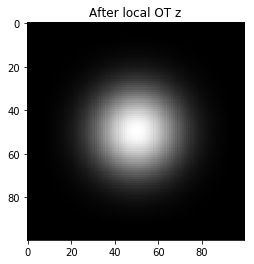

Step k = 18


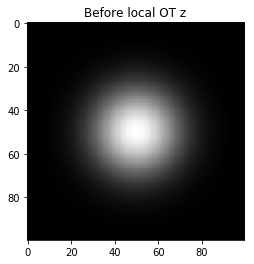

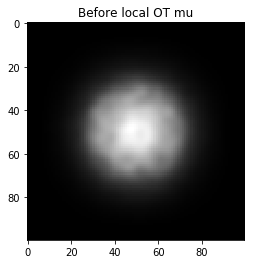

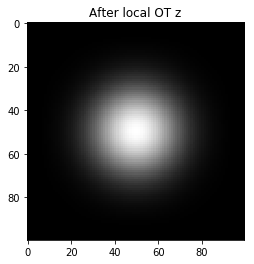

Step k = 19


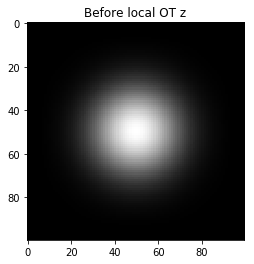

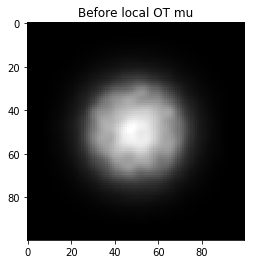

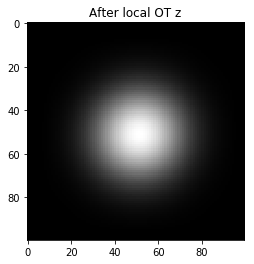

Step k = 20


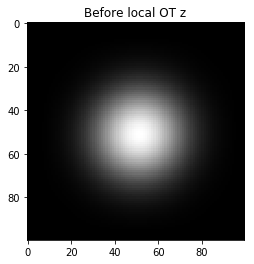

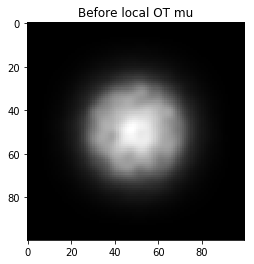

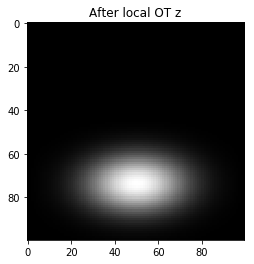

Step k = 21


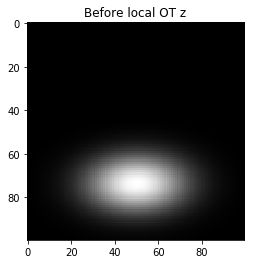

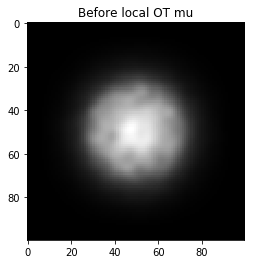

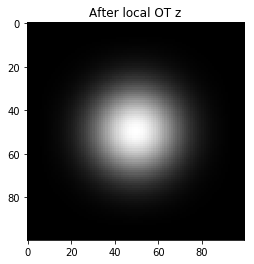

Step k = 22


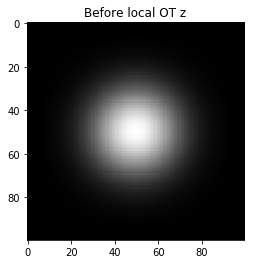

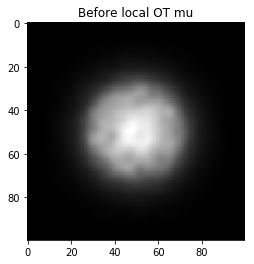

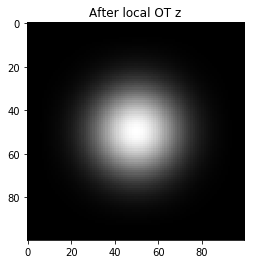

Step k = 23


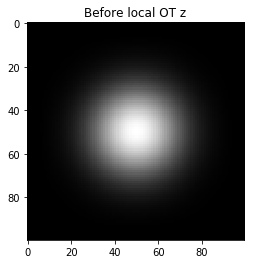

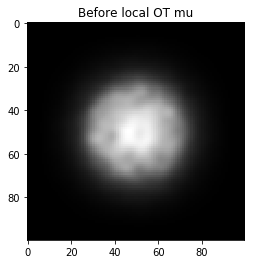

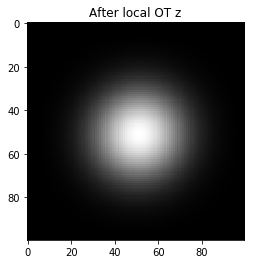

Step k = 24


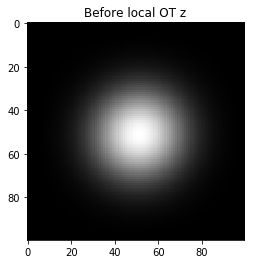

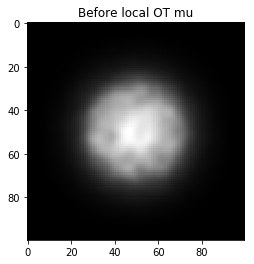

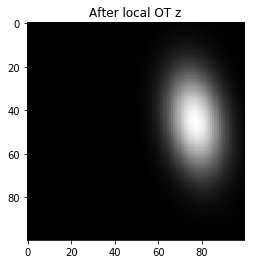

Step k = 25


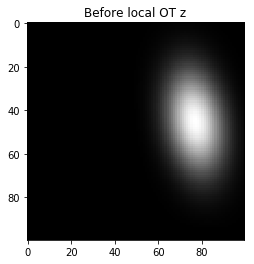

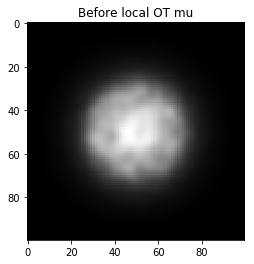

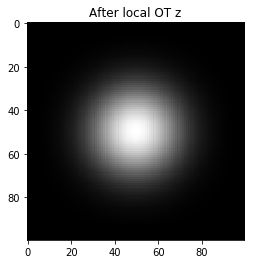

Step k = 26


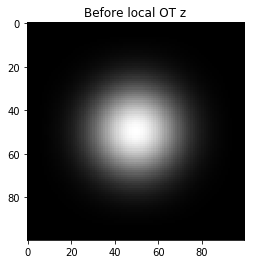

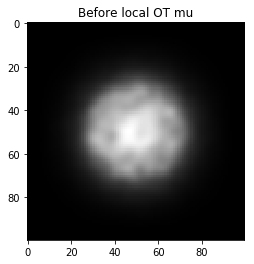

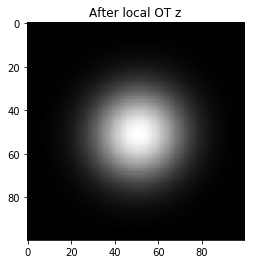

Step k = 27


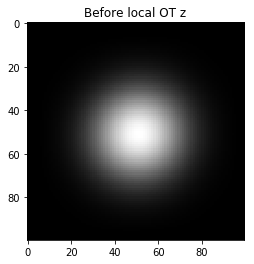

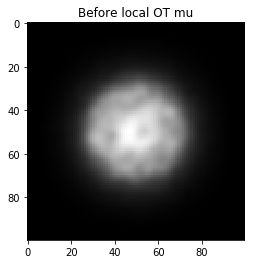

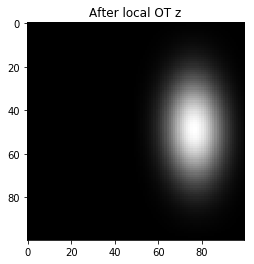

Step k = 28


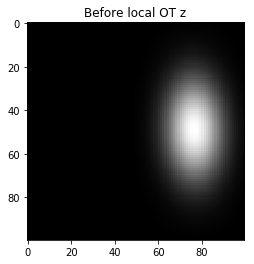

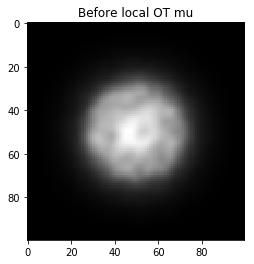

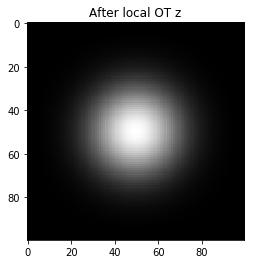

Step k = 29


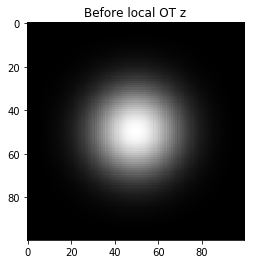

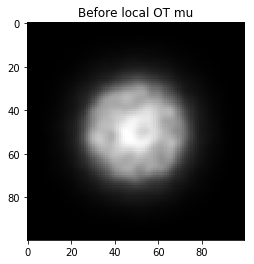

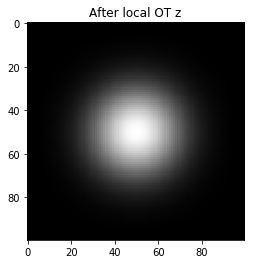

Step k = 30


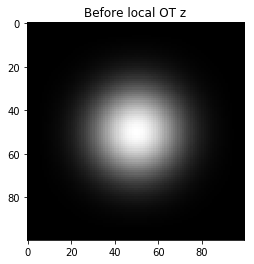

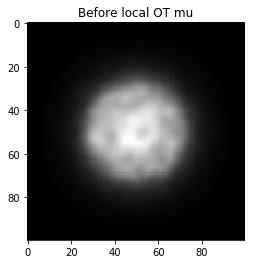

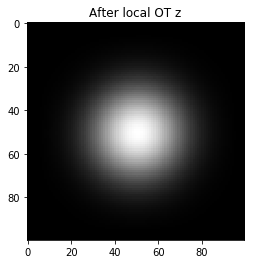

Step k = 31


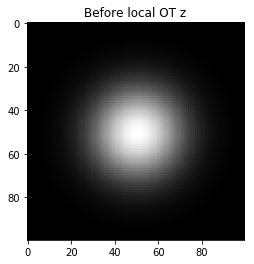

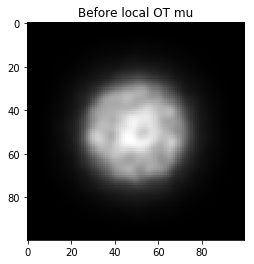

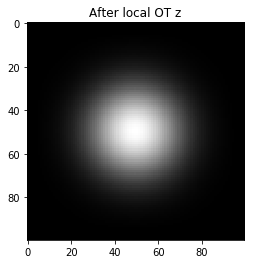

Step k = 32


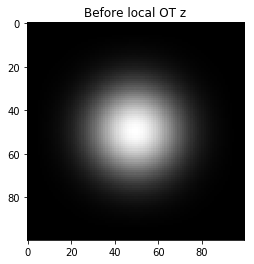

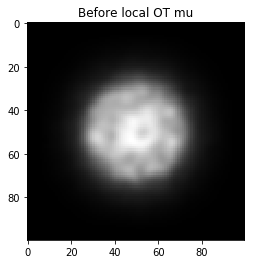

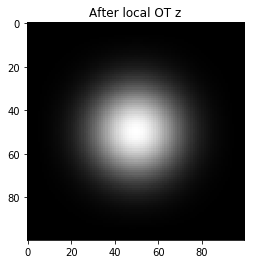

Step k = 33


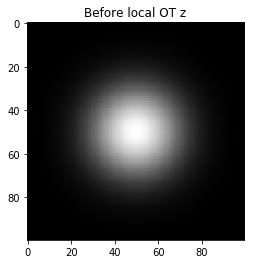

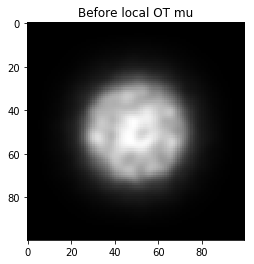

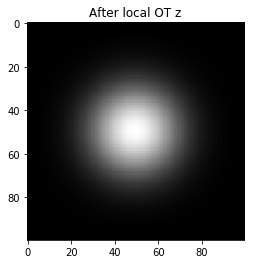

Step k = 34


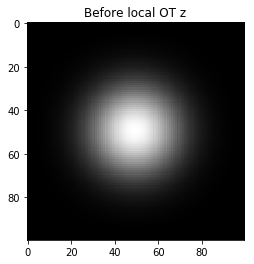

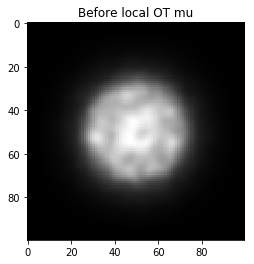

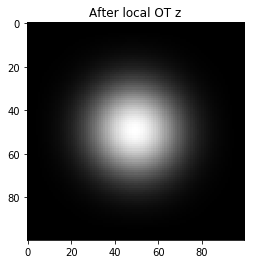

Step k = 35


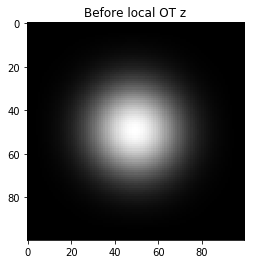

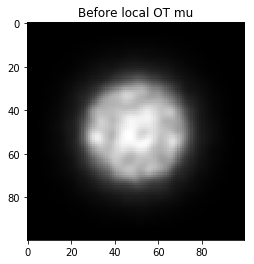

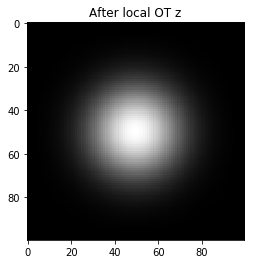

Step k = 36


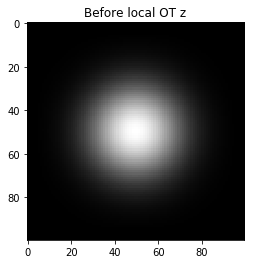

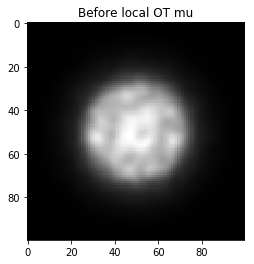

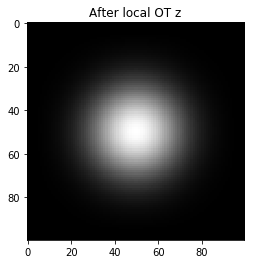

Step k = 37


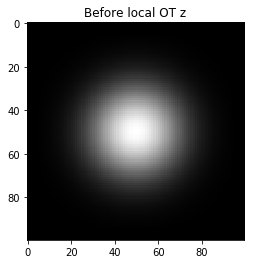

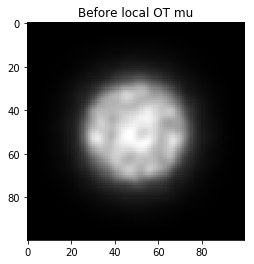

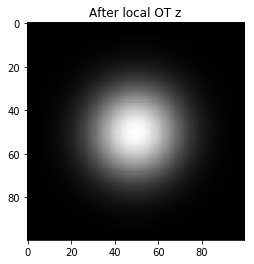

Step k = 38


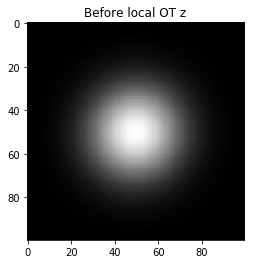

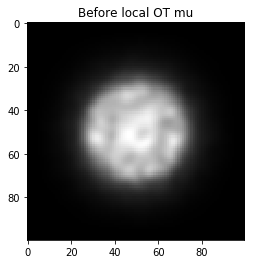

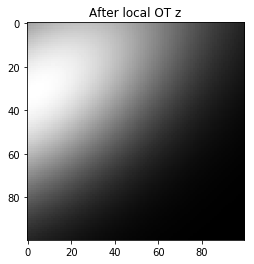

Step k = 39


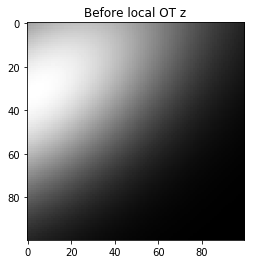

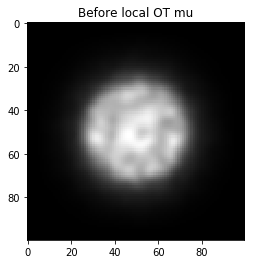

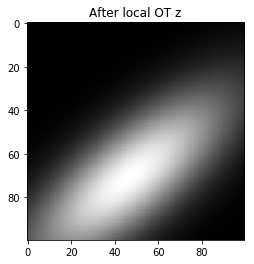

Step k = 40


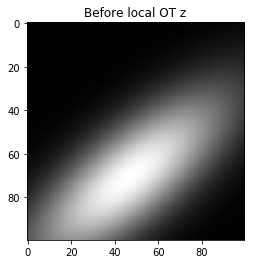

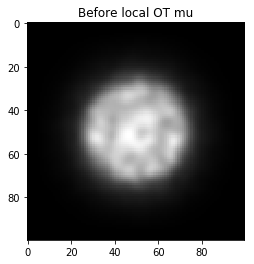

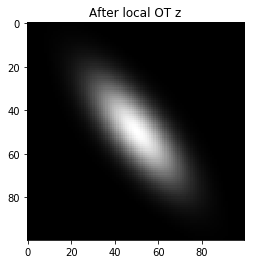

Step k = 41


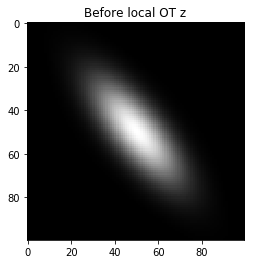

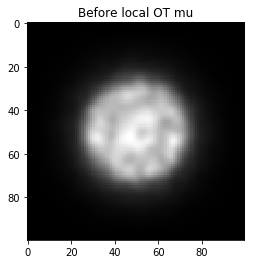

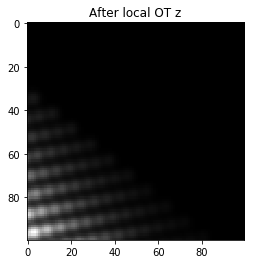

Step k = 42


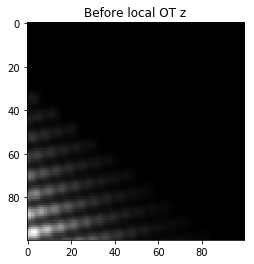

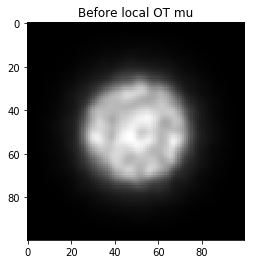

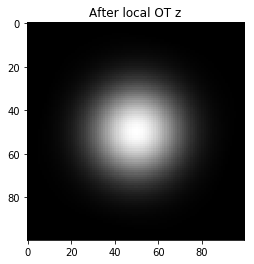

Step k = 43


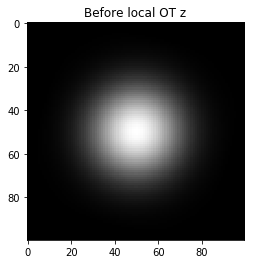

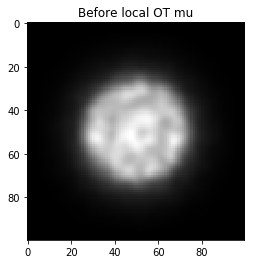

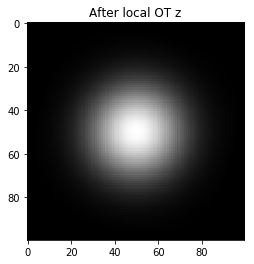

Step k = 44


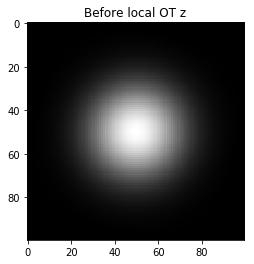

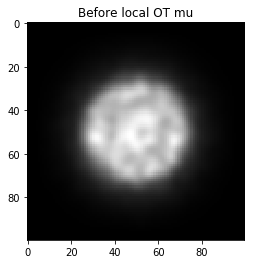

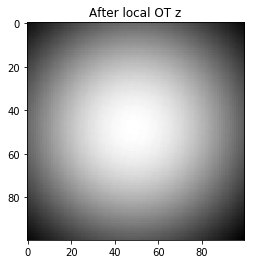

Step k = 45


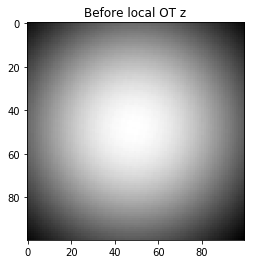

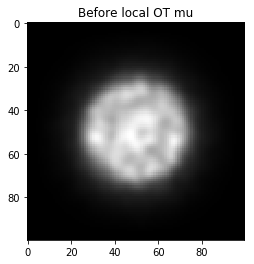

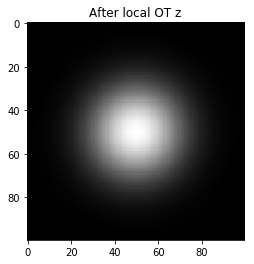

Step k = 46


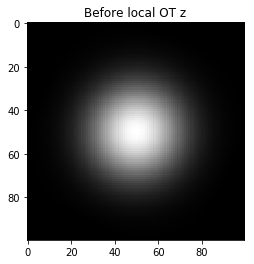

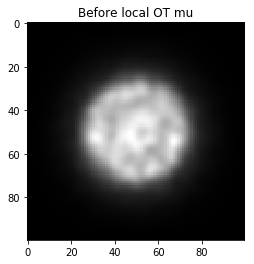

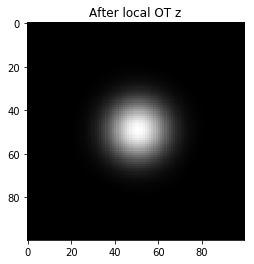

Step k = 47


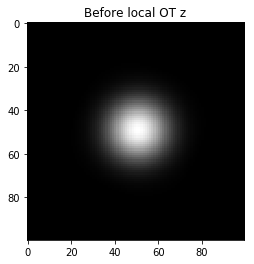

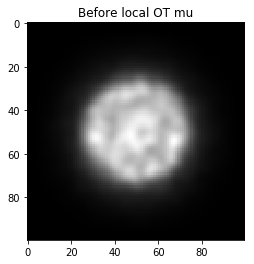

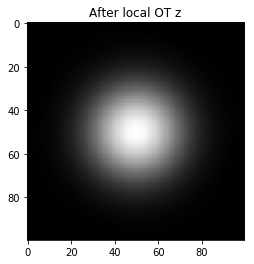

Step k = 48


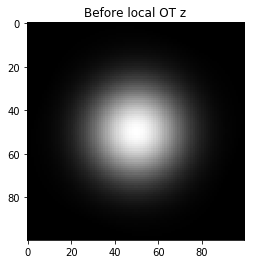

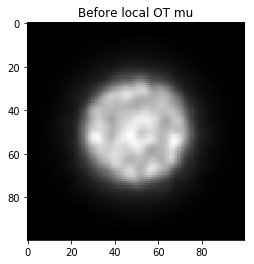

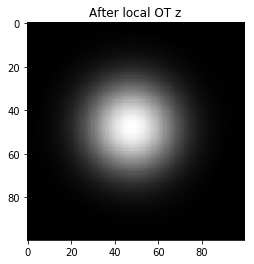

Step k = 49


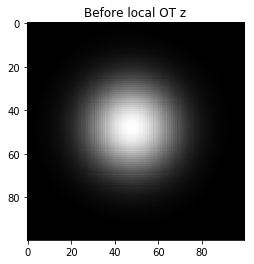

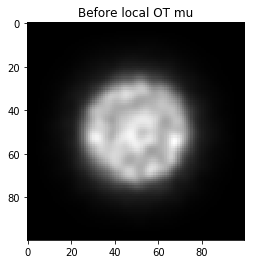

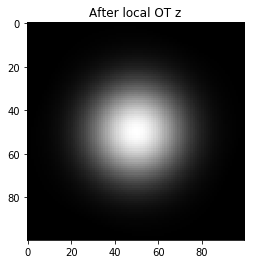

Step k = 50


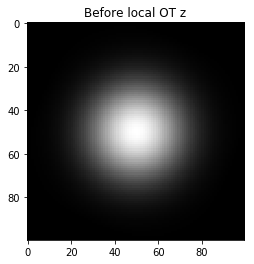

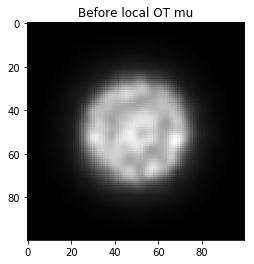

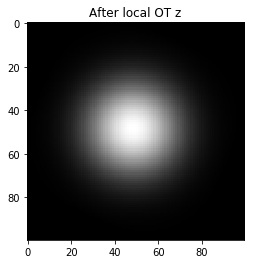

Step k = 51


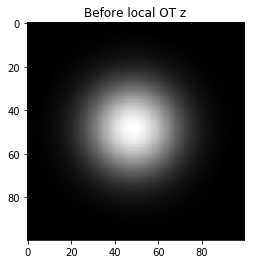

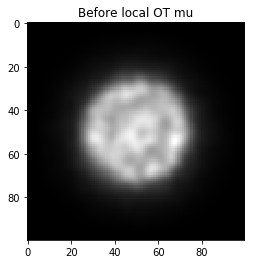

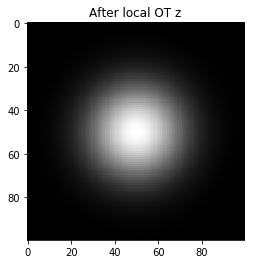

Step k = 52


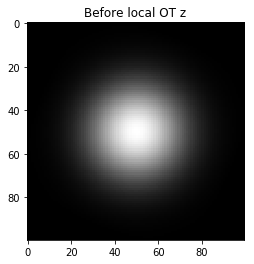

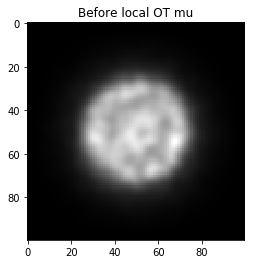

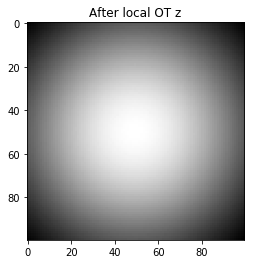

Step k = 53


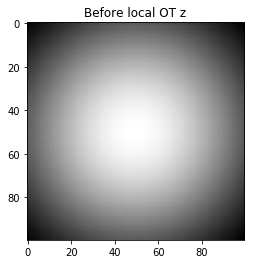

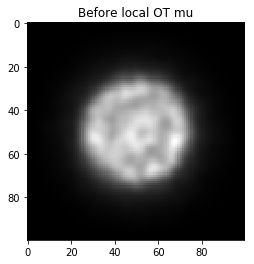

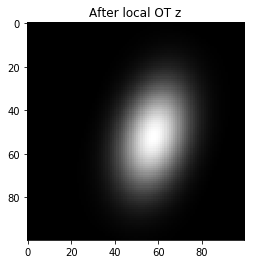

Step k = 54


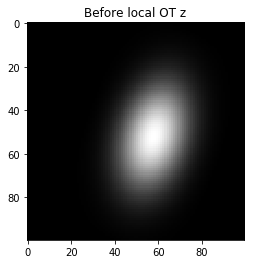

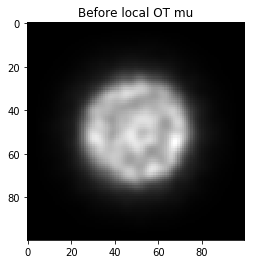

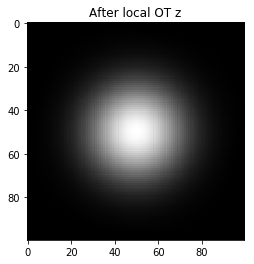

Step k = 55


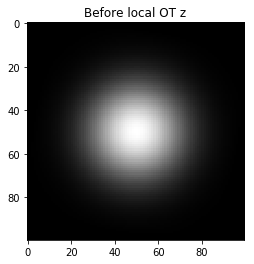

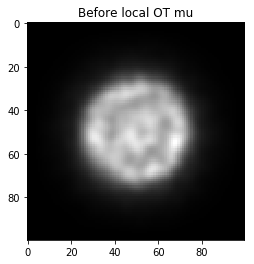

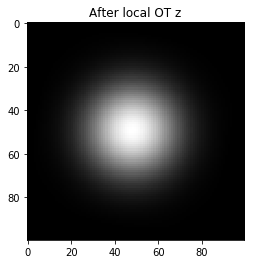

Step k = 56


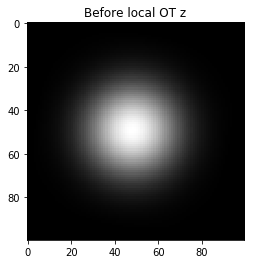

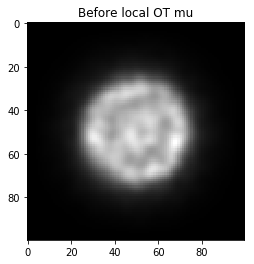

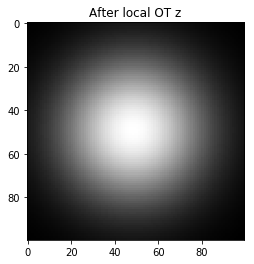

Step k = 57


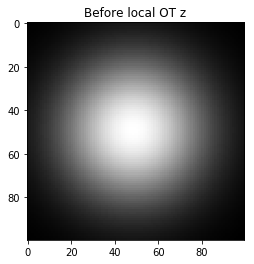

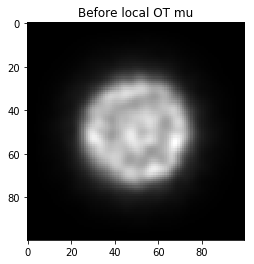

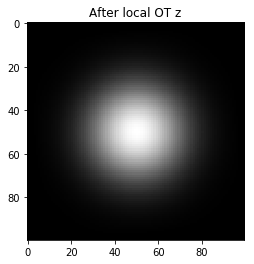

Step k = 58


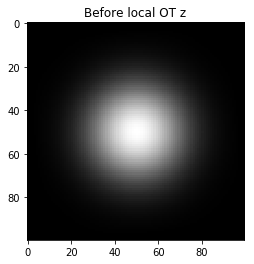

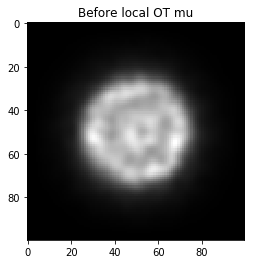

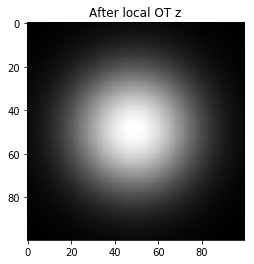

Step k = 59


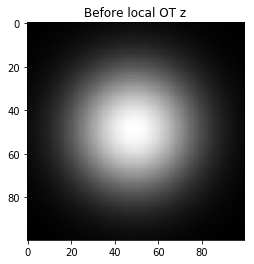

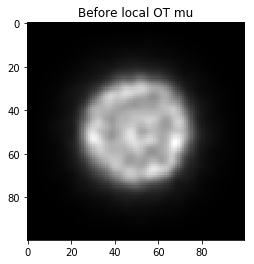

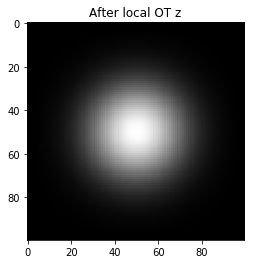

Step k = 60


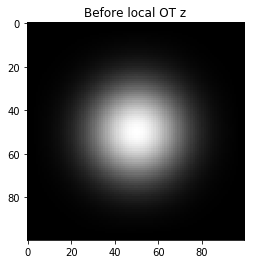

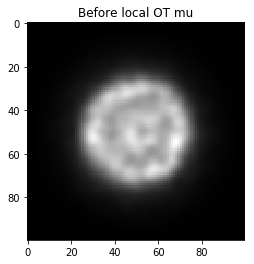

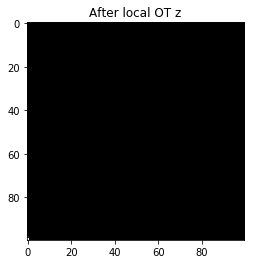

Step k = 61


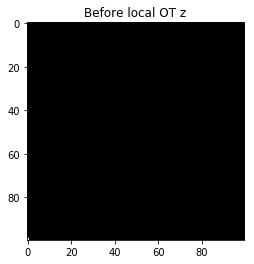

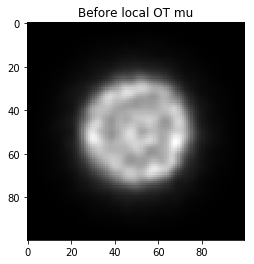

In [ ]:
x_K,a_maps,b_maps = global_ot(x,y,K=200)